In [ ]:
!pip3 install helpers

In [ ]:
pip install gdown

In [ ]:
%matplotlib inline
%tensorflow_version 2.x
import os
import random
import pathlib
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
from tqdm import tqdm

import tensorflow as tf
from keras.utils import np_utils, to_categorical
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Activation, Dropout, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.activations import relu, softmax

import sklearn.metrics as mt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

GPU = tf.device('/device:GPU:0')

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

__CWDIR__ = pathlib.Path.cwd()
MFCC_FILE_DIR = __CWDIR__.joinpath('drive').joinpath('My Drive').joinpath('Colab_Files').joinpath('mfcc_plot')
MFCC_FILE = os.listdir(MFCC_FILE_DIR)
MFCC_FILE = [str(MFCC_FILE_DIR.joinpath(file)) for file in MFCC_FILE]

WAV_BASEDIR = __CWDIR__.joinpath('drive').joinpath('My Drive').joinpath('Colab_Files').joinpath('speech-emotion-recognition-ravdess-data')
ACTOR_LIST = os.listdir(WAV_BASEDIR)
ACTOR_FILE_LIST = [WAV_BASEDIR.joinpath(file) for file in ACTOR_LIST]

CLASSES = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
'''
1. Data Preprocessing.  
'''
def load_data_handler():
    male_wav_file_list, male_y, female_wav_file_list, female_y = [], [], [], []
    for idx, file in enumerate(ACTOR_FILE_LIST):
        for wav in os.listdir(file):
            if wav:
                source = str(file) +'/'+ wav
                if (idx+1) % 2 == 0:
                    female_wav_file_list.append(source)
                    female_y.append(int(wav.split('-')[2][1:2]))
                else:
                    male_wav_file_list.append(str(file) +'/'+ wav)
                    male_y.append(int(wav.split('-')[2][1:2]))
    
    # merging
    path = pd.Series(male_wav_file_list + female_wav_file_list).rename('path')
    y = pd.Series(male_y + female_y).rename('y')
    merge_df = pd.concat([path, y], axis=1)

    # split female and male
    male_path = pd.Series(male_wav_file_list).rename('male_path')
    female_path = pd.Series(female_wav_file_list).rename('female_path')
    male_y = pd.Series(male_y).rename('male_y')
    female_y = pd.Series(female_y).rename('female_y')
    male_df = pd.concat([male_path, male_y], axis=1)
    female_df = pd.concat([female_path, female_y], axis=1)
    return male_df, female_df, merge_df

'''
2. Extracting the MFCC feature as an image (Matrix format).  
'''
def prepare_mfcc(df, n, gender=None, mfcc=True):
    X = np.empty(shape=(df.shape[0], n, 216, 1))
    input_length = sampling_rate * audio_duration
    
    cnt = 0
    
    if gender == 'female': 
      col = 'female_path'
    elif gender == 'male':
      col = 'male_path'
    elif not gender:
      col = 'path'

    for fname in tqdm(df[col]):
        file_path = fname
        data, _ = librosa.load(file_path, sr=sampling_rate
                               ,res_type="kaiser_fast"
                               ,duration=2.5
                               ,offset=0.5
                              )

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, int(input_length) - len(data) - offset), "constant")
        
        # Feature
        if mfcc:
            # MFCC extraction 
            MFCC = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=n)
            MFCC = np.expand_dims(MFCC, axis=-1)
            X[cnt,] = MFCC
        cnt += 1
    return X

male_df, female_df, merge_df = load_data_handler()

sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
male_mfcc = prepare_mfcc(male_df, n= n_mfcc, gender='male', mfcc=True)
female_mfcc = prepare_mfcc(female_df, n= n_mfcc, gender='female', mfcc=True)
merge_mfcc = prepare_mfcc(merge_df, n= n_mfcc, gender=None, mfcc=True)

100%|██████████| 1440/1440 [07:02<00:00,  3.41it/s]


In [ ]:
# all mfcc
X, Y = merge_mfcc, merge_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=True, random_state=42)
# male and female seperation
male_xx, male_yy, female_xx, female_yy = male_mfcc, male_df['male_y'], female_mfcc, female_df['female_y']

Xm_train, Xm_test, ym_train, ym_test = train_test_split(male_xx, male_yy, test_size=0.25, shuffle=True, random_state=42)
Xfm_train, Xfm_test, yfm_train, yfm_test = train_test_split(female_xx, female_yy, test_size=0.25, shuffle=True, random_state=42)



In [ ]:
def cnn_model(n):
    with GPU:
        nclass = len(CLASSES)
        inp = Input(shape=(n,216,1))  #2D matrix of 30 MFCC bands by 216 audio length.
        x = Conv2D(32, (4,10), padding="same")(inp)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = MaxPooling2D()(x)
        x = Dropout(rate=0.2)(x)
        
        x = Conv2D(32, (4,10), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = MaxPooling2D()(x)
        x = Dropout(rate=0.2)(x)
        
        x = Conv2D(32, (4,10), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = MaxPooling2D()(x)
        x = Dropout(rate=0.2)(x)
        
        x = Conv2D(32, (4,10), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = MaxPooling2D()(x)
        x = Dropout(rate=0.2)(x)
        
        x = Flatten()(x)
        x = Dense(64)(x)
        x = Dropout(rate=0.2)(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Dropout(rate=0.2)(x)
        
        out = Dense(nclass, activation=softmax)(x)
        model = Model(inputs=inp, outputs=out)
        return model

def get_optimizer():
    opt = tf.keras.optimizers.RMSprop(
          learning_rate=0.0001, epsilon=1e-6, name='RMSprop'
    )
    return opt

In [ ]:
# label encoding
def encoding_label(y):
    lb = LabelEncoder()
    y = np_utils.to_categorical(lb.fit_transform(y))
    return y
 
# Normalization as per the standard NN process
def normalization(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X = (X - mean)/std
    return X
 
# Build CNN model
def build_cnn_model(n_mfcc, X_train, y_train, X_test, y_test, epochs=200): 
    model = cnn_model(n=n_mfcc)
    model.summary()
    model.compile(optimizer=get_optimizer(), loss='categorical_crossentropy', metrics=['accuracy'])
    model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                        batch_size=16, verbose = 2, epochs=epochs, use_multiprocessing=True)
    return model, model_history
 
def evaluate(X_train, y_train, X_test, y_test):
    score = model.evaluate(X_train, y_train, verbose=0)
    print("Training Accuracy: ", score[1])
    score = model.evaluate(X_test, y_test, verbose=0)
    print("Testing Accuracy: ", score[1])
 
def numerical_to_emotion(x:int):
    return CLASSES[x-1]
 
def plot_confusion_matrix(y_pred, y_test):
    cm = mt.confusion_matrix(y_test, y_pred)
    print(mt.classification_report(y_test, y_pred))
    index = CLASSES
    columns = CLASSES
    cm_df = pd.DataFrame(cm,index,columns)                      
    plt.figure(figsize=(10,6))  
    sns.heatmap(cm_df, annot=True)

def plot_acc_vs_epoch(model_history):
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    return plt

def plot_loss_vs_epoch(model_history):
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    return plt


68/68 - 1s - loss: 0.1212 - accuracy: 0.9722 - val_loss: 0.7928 - val_accuracy: 0.7583
Epoch 211/250
68/68 - 1s - loss: 0.1355 - accuracy: 0.9611 - val_loss: 0.7461 - val_accuracy: 0.7528
Epoch 212/250
68/68 - 1s - loss: 0.1198 - accuracy: 0.9685 - val_loss: 0.7623 - val_accuracy: 0.7639
Epoch 213/250
68/68 - 1s - loss: 0.1315 - accuracy: 0.9648 - val_loss: 0.7283 - val_accuracy: 0.7556
Epoch 214/250
68/68 - 1s - loss: 0.1280 - accuracy: 0.9657 - val_loss: 0.7014 - val_accuracy: 0.7833
Epoch 215/250
68/68 - 1s - loss: 0.1336 - accuracy: 0.9528 - val_loss: 0.7968 - val_accuracy: 0.7333
Epoch 216/250
68/68 - 1s - loss: 0.1273 - accuracy: 0.9593 - val_loss: 0.7721 - val_accuracy: 0.7583
Epoch 217/250
68/68 - 1s - loss: 0.1383 - accuracy: 0.9630 - val_loss: 0.7205 - val_accuracy: 0.7944
Epoch 218/250
68/68 - 1s - loss: 0.1256 - accuracy: 0.9574 - val_loss: 0.8077 - val_accuracy: 0.7583
Epoch 219/250
68/68 - 1s - loss: 0.1689 - accuracy: 0.9417 - val_loss: 0.7486 - val_accuracy: 0.7778
Epoc

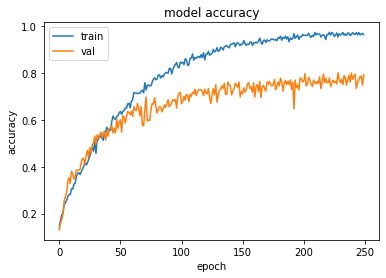

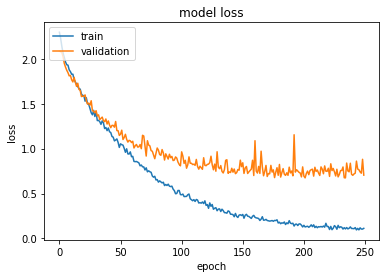

Training Accuracy:  1.0
Testing Accuracy:  0.7916666865348816
              precision    recall  f1-score   support

       angry       0.81      0.80      0.80        44
        calm       0.86      0.62      0.72        50
     disgust       0.83      0.92      0.87        52
     fearful       0.82      0.80      0.81        50
       happy       0.62      0.67      0.64        42
     neutral       0.75      0.90      0.82        51
         sad       0.85      0.87      0.86        45
   surprised       0.82      0.69      0.75        26

    accuracy                           0.79       360
   macro avg       0.80      0.78      0.78       360
weighted avg       0.80      0.79      0.79       360



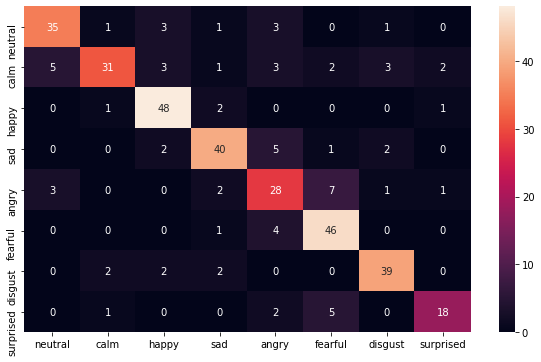

In [ ]:
# MIX
X_train = normalization(X_train)
X_test = normalization(X_test)
y_train = encoding_label(y_train)
y_test = encoding_label(y_test)
with GPU:
    model, model_history = build_cnn_model(n_mfcc, X_train, y_train, X_test, y_test, epochs=250)
plt = plot_acc_vs_epoch(model_history)
plt.show()
plt = plot_loss_vs_epoch(model_history)
plt.show()
evaluate(X_train, y_train, X_test, y_test)

y_pred = model.predict(X_test)
y_pred = [np.argmax(y, axis=None, out=None) for y in y_pred]
y_test = [np.argmax(y, axis=None, out=None) for y in y_test]
 
y_pred = [numerical_to_emotion(x) for x in y_pred]
y_test = [numerical_to_emotion(x) for x in y_test]
plot_confusion_matrix(y_pred, y_test)

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 30, 216, 1)]      0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 30, 216, 32)       1312      
_________________________________________________________________
batch_normalization_80 (Batc (None, 30, 216, 32)       128       
_________________________________________________________________
activation_80 (Activation)   (None, 30, 216, 32)       0         
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 15, 108, 32)       0         
_________________________________________________________________
dropout_177 (Dropout)        (None, 15, 108, 32)       0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 15, 108, 32)       409

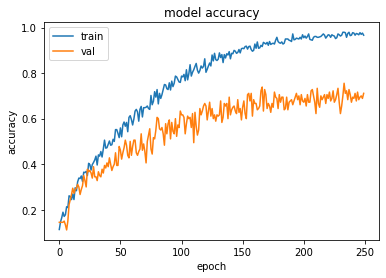

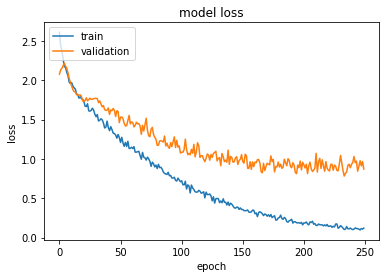

Training Accuracy:  1.0
Testing Accuracy:  0.7111111283302307
              precision    recall  f1-score   support

       angry       0.61      0.74      0.67        27
        calm       0.58      0.44      0.50        25
     disgust       0.92      0.77      0.84        30
     fearful       0.76      0.65      0.70        20
       happy       0.87      0.54      0.67        24
     neutral       0.70      1.00      0.82        16
         sad       0.77      0.83      0.80        24
   surprised       0.55      0.86      0.67        14

    accuracy                           0.71       180
   macro avg       0.72      0.73      0.71       180
weighted avg       0.73      0.71      0.71       180



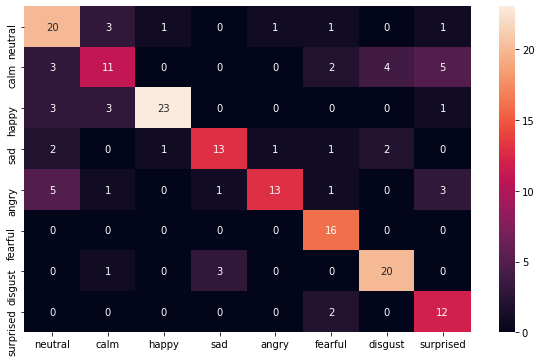

In [ ]:
# MALE
Xm_train = normalization(Xm_train)
Xm_test = normalization(Xm_test)
ym_train = encoding_label(ym_train)
ym_test = encoding_label(ym_test)
with GPU:
    model, model_history = build_cnn_model(n_mfcc, Xm_train, ym_train, Xm_test, ym_test, epochs=250)
plt = plot_acc_vs_epoch(model_history)
plt.show()
plt = plot_loss_vs_epoch(model_history)
plt.show()
evaluate(Xm_train, ym_train, Xm_test, ym_test)

y_pred = model.predict(Xm_test)
y_pred = [np.argmax(y, axis=None, out=None) for y in y_pred]
ym_test = [np.argmax(y, axis=None, out=None) for y in ym_test]
 
y_pred = [numerical_to_emotion(x) for x in y_pred]
ym_test = [numerical_to_emotion(x) for x in ym_test]
 
plot_confusion_matrix(y_pred, ym_test)

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 30, 216, 1)]      0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 30, 216, 32)       1312      
_________________________________________________________________
batch_normalization_85 (Batc (None, 30, 216, 32)       128       
_________________________________________________________________
activation_85 (Activation)   (None, 30, 216, 32)       0         
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 15, 108, 32)       0         
_________________________________________________________________
dropout_183 (Dropout)        (None, 15, 108, 32)       0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 15, 108, 32)       409

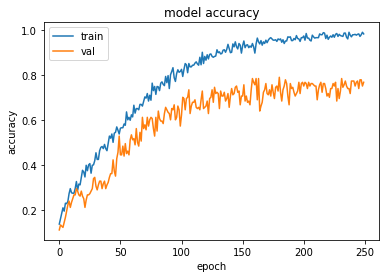

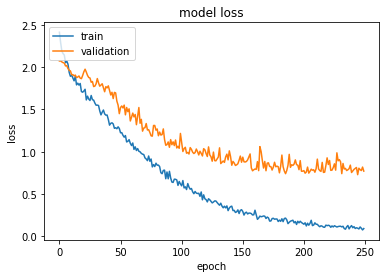

Training Accuracy:  1.0
Testing Accuracy:  0.7666666507720947
              precision    recall  f1-score   support

       angry       0.88      0.85      0.86        26
        calm       0.73      0.67      0.70        24
     disgust       0.79      0.70      0.75        27
     fearful       0.89      0.68      0.77        25
       happy       0.64      0.80      0.71        20
     neutral       0.70      0.95      0.81        20
         sad       0.78      0.84      0.81        25
   surprised       0.73      0.62      0.67        13

    accuracy                           0.77       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.77      0.77       180



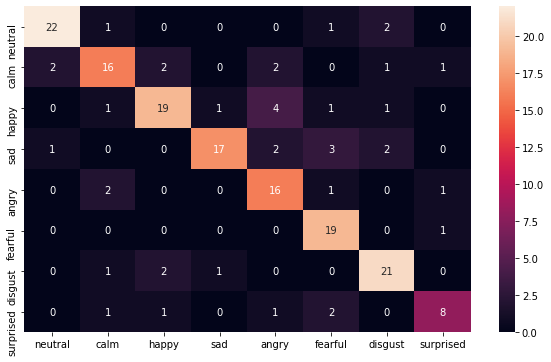

In [ ]:
# FEMALE
Xfm_train = normalization(Xfm_train)
Xfm_test = normalization(Xfm_test)
yfm_train = encoding_label(yfm_train)
yfm_test = encoding_label(yfm_test)

with GPU:
    model, model_history = build_cnn_model(n_mfcc, Xfm_train, yfm_train, Xfm_test, yfm_test, epochs=250)
plt = plot_acc_vs_epoch(model_history)
plt.show()
plt = plot_loss_vs_epoch(model_history)
plt.show()
evaluate(Xfm_train, yfm_train, Xfm_test, yfm_test)

y_pred = model.predict(Xfm_test)
y_pred = [np.argmax(y, axis=None, out=None) for y in y_pred]
yfm_test = [np.argmax(y, axis=None, out=None) for y in yfm_test]

y_pred = [numerical_to_emotion(x) for x in y_pred]
yfm_test = [numerical_to_emotion(x) for x in yfm_test]

plot_confusion_matrix(y_pred, yfm_test)